In [1]:
# Read the dataset
import scipy.io as spio
import numpy as np

BahramFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/SarahFace.mat')

AllData = np.concatenate((BahramFace['Intensification_Data'],
                            DJFace['Intensification_Data'],
                            NickFace['Intensification_Data'],
                            RoohiFace['Intensification_Data'],
                            SarahFace['Intensification_Data']), axis=0)

AllLabels = np.concatenate((BahramFace['Intensification_Label'],
                            DJFace['Intensification_Label'],
                            NickFace['Intensification_Label'],
                            RoohiFace['Intensification_Label'],
                            SarahFace['Intensification_Label']), axis=0)

print(AllData.shape, AllData.dtype, AllLabels.shape, AllLabels.dtype)
print(np.mean(AllLabels==0), np.mean(AllLabels==1), np.mean(AllLabels==2), np.mean(AllLabels==3))
print((AllLabels +  1).max(axis=0))

(18720, 205, 16) float64 (18720, 1) uint8
0.833333333333 0.166666666667 0.0 0.0
[2]


In [2]:
# Train and test split
from sklearn.model_selection import train_test_split

X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllData, AllLabels, test_size=0.30)

print(X_train_valid.shape, X_test.shape, Y_train_valid.shape, Y_test.shape)

(13104, 205, 16) (5616, 205, 16) (13104, 1) (5616, 1)


In [3]:
from utilities import *

# Normalizing/standardizing the input data features
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# Onehot encoding/vectorizing the output data labels
print(np.mean((Y_train_valid+1).reshape(-1)==0), np.mean((Y_train_valid+1).reshape(-1)==1),
     np.mean((Y_train_valid+1).reshape(-1)==2), np.mean((Y_train_valid+1).reshape(-1)==3))

print(np.mean((Y_test+1).reshape(-1)==0), np.mean((Y_test+1).reshape(-1)==1),
     np.mean((Y_test+1).reshape(-1)==2), np.mean((Y_test+1).reshape(-1)==3))

# Y_train_valid_onehot = one_hot(labels=(Y_train_valid+1).reshape(-1), n_class=2) 
# print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
Y_test_onehot = one_hot(labels=(Y_test+1).reshape(-1), n_class=2) 
print(Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.834325396825 0.165674603175 0.0
0.0 0.831018518519 0.168981481481 0.0
(5616, 2) float64


In [5]:
# 70% train 30 % valid
# get_batches from each train and valid the same
# still it will be 70% to 30%
# get_batches 83% vs 16%
# get_batch 16% vs 16% each time
# X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllData, AllLabels, test_size=0.30)
X_train_norm, X_valid_norm, Y_train, Y_valid = train_test_split(X_train_valid_norm, Y_train_valid, 
                                                                              test_size=0.30)

In [38]:
# def get_batches(X, Y, batch_size = 100):
#     """ Return a generator for batches """
#     n_batches = len(X) // batch_size
#     X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

#     # Loop over batches and yield
#     for b in range(0, len(X), batch_size):
#         yield X[b:b+batch_size], y[b:b+batch_size]

In [6]:
def get_batches2(X_norm, Y_labels):
    # Input train or valid
    # This is not-applicable to test
    X, Y = X_norm, Y_labels #_onehot
    AllLabels = Y_labels # 100%

    # non = 0 is 87%  AllLabelZero
    # tgt = 1 is 13%  AllLabelOne
    AllLabelZero = (AllLabels==0).reshape(-1) # 87%
    AllLabelOne = (AllLabels==1).reshape(-1) # 13%

    X_non, Y_non = X[AllLabelZero], Y[AllLabelZero] # 87%
    X_tgt, Y_tgt = X[AllLabelOne], Y[AllLabelOne] # 13%
#     print('X_non.shape, Y_non.shape', X_non.shape, Y_non.shape)
#     print('X_tgt.shape, Y_tgt.shape', X_tgt.shape, Y_tgt.shape)

    # Non-target batch size for get_batches from non-target data
    batch_size = X_tgt.shape[0] # 13% -> tgt = 1 is 13%  AllLabelOne
    assert X_tgt.shape[0] == Y_tgt.shape[0]
#     print(batch_size)

    # # 87% - 13% +1: non - tgt + 1
    # n_batches = X_non.shape[0] - tgt_batch_size + 1 # stride=1 
    # # max overlap for non-tgt 87% - 13% +1

#     # 87% // 13%: non/ tgt
#     # max overlap for non-tgt 87%// 13%
#     num_non_batches = X_non.shape[0]// tgt_batch_size # stride= tgt_batch_size 
# #     print(num_non_batches)
#     # # n_batches = len(X) // batch_size # stride=batch_size # min overlap
#     X_non_, Y_non_ = X_non[:num_non_batches*tgt_batch_size], Y_non[:num_non_batches*tgt_batch_size]

    """ Return a generator for batches """
    n_batches = X_non.shape[0] // batch_size
    X_non, Y_non = X_non[:n_batches*batch_size], Y_non[:n_batches*batch_size]
    
#     """ Return a generator for batches """
#     n_batches = len(X) // batch_size
#     X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over target batches: start, stop, step
    for i in range(0, X_non.shape[0], batch_size):
#         print(i)
        # each_train_valid_batch
        each_X_norm = np.concatenate((X_non[i:i+batch_size], X_tgt), axis=0)
        each_Y = np.concatenate((Y_non[i:i+batch_size], Y_tgt), axis=0)
        each_Y_onehot = one_hot(labels=(each_Y+1).reshape(-1), n_class=2)
#         print('each_X_norm.shape, each_Y_onehot.shape', each_X_norm.shape, each_Y_onehot.shape)
#         print('each_X_norm.dtype, each_Y_onehot.dtype', each_X_norm.dtype, each_Y_onehot.dtype)
        yield each_X_norm, each_Y_onehot
        
    #     # Loop over batches and yield
    #     for b in range(0, len(X), batch_size):
    #         yield X[b:b+batch_size], y[b:b+batch_size]

In [7]:
get_batches2(X_norm=X_valid_norm, Y_labels=Y_valid)

<generator object get_batches2 at 0x7f6a29b88830>

In [8]:
get_batches2(X_norm=X_train_norm, Y_labels=Y_train)

<generator object get_batches2 at 0x7f6a29be5728>

In [9]:
## Hyperparameters
# Input data
# batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
# print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)
print('seq_len, n_channels', seq_len, n_channels)

# Output labels
n_classes = Y_train_valid.max(axis=0)+1
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.0001 #1e-4
epochs = 1000 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

seq_len, n_channels 205 16
n_classes [2]


In [10]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [12]:
# Feed the data from python/numpy to tensorflow framework
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')
print('inputs_.shape, labels_.shape', inputs_.shape, labels_.shape)

inputs_.shape, labels_.shape (?, 205, 16) (?, 2)


In [13]:
# inputs_.shape, labels_.shape (?, 205, 16) (?, 2)
# (batch, 205, 16) --> (batch, 102, 32)
# conv valid: (205-2+0)/1 + 1 = (203/1)+1 = 203 + 1=204
# pool same: (204-2+0)/2 + 1 = (202/2)+1 = 101 + 1=102
conv1 = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
# max_pool_1 = tf.nn.dropout(max_pool_1, keep_prob=keep_prob_)
print('inputs_.shape, conv1.shape, max_pool_1.shape', inputs_.shape, conv1.shape, max_pool_1.shape)

# (batch, 102, 32) --> (batch, 51, 64)
# conv same
# pool same: (102-2+0)/2 + 1 = (100/2)+1 = 50 + 1=51
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=64, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
# max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print('max_pool_1.shape, conv2.shape, max_pool_2.shape', max_pool_1.shape, conv2.shape, max_pool_2.shape)

# (batch, 51, 64) --> (batch, 25, 128)
# conv valid: (51-2+0)/1 + 1 = (49/1)+1 = 49 + 1=50
# pool same: (50-2+0)/2 + 1 = (48/2)+1 = 24 + 1=25
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=128, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
# max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print('max_pool_2.shape, conv3.shape, max_pool_3.shape', max_pool_2.shape, conv3.shape, max_pool_3.shape)

# (batch, 25, 128) --> (batch, 12, 256)
# conv valid: (25-2+0)/1 + 1 = (23/1)+1 = 23 + 1=24
# pool same: (24-2+0)/2 + 1 = (22/2)+1 = 11 + 1=12
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=256, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
# max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print('max_pool_3.shape, conv4.shape, max_pool_4.shape', max_pool_3.shape, conv4.shape, max_pool_4.shape)

# Flatten and add dropout + predicted output
flat = tf.reshape(max_pool_4, (-1, 12*256))
flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
logits = tf.layers.dense(flat, n_classes)
print('max_pool_4.shape, flat.shape, logits.shape', max_pool_4.shape, flat.shape, logits.shape)

inputs_.shape, conv1.shape, max_pool_1.shape (?, 205, 16) (?, 204, 32) (?, 102, 32)
max_pool_1.shape, conv2.shape, max_pool_2.shape (?, 102, 32) (?, 102, 64) (?, 51, 64)
max_pool_2.shape, conv3.shape, max_pool_3.shape (?, 51, 64) (?, 50, 128) (?, 25, 128)
max_pool_3.shape, conv4.shape, max_pool_4.shape (?, 25, 128) (?, 24, 256) (?, 12, 256)
max_pool_4.shape, flat.shape, logits.shape (?, 12, 256) (?, 3072) (?, 2)


In [14]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)
print('cost_tensor, cost', cost_tensor, cost)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)
print('optimizer', optimizer)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print('correct_pred, accuracy', correct_pred, accuracy)

# Confusion matrix
confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
                                       labels=tf.argmax(labels_, 1))
print('confusion_matrix', confusion_matrix)

cost_tensor, cost Tensor("Reshape_3:0", shape=(?,), dtype=float32) Tensor("Mean:0", shape=(), dtype=float32)
optimizer name: "Adam"
op: "NoOp"
input: "^Adam/update_conv1d/kernel/ApplyAdam"
input: "^Adam/update_conv1d/bias/ApplyAdam"
input: "^Adam/update_conv1d_1/kernel/ApplyAdam"
input: "^Adam/update_conv1d_1/bias/ApplyAdam"
input: "^Adam/update_conv1d_2/kernel/ApplyAdam"
input: "^Adam/update_conv1d_2/bias/ApplyAdam"
input: "^Adam/update_conv1d_3/kernel/ApplyAdam"
input: "^Adam/update_conv1d_3/bias/ApplyAdam"
input: "^Adam/update_dense/kernel/ApplyAdam"
input: "^Adam/update_dense/bias/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"

correct_pred, accuracy Tensor("Equal:0", shape=(?,), dtype=bool) Tensor("accuracy:0", shape=(), dtype=float32)
confusion_matrix Tensor("confusion_matrix/SparseTensorDenseAdd:0", shape=(?, ?), dtype=int32)


In [15]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
#         for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
        for x, y in get_batches2(X_norm=X_train_norm, Y_labels=Y_train):
            
            ######################## Training
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################## Validation
            acc_batch = []
            loss_batch = []    
            # Loop over batches
#             for x, y in get_batches(X_valid_norm, Y_valid_onehot, batch_size):
            for x, y in get_batches2(X_norm=X_valid_norm, Y_labels=Y_valid):

                # Feed dictionary
                feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

                # Loss
                loss, acc = sess.run([cost, accuracy], feed_dict = feed)
                acc_batch.append(acc)
                loss_batch.append(loss)

            # Store
            valid_acc.append(np.mean(acc_batch))
            valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(valid_loss)),
              "Train acc: {:6f}".format(np.mean(train_acc)),
              "Valid acc: {:.6f}".format(np.mean(valid_acc)))
                
    saver.save(sess,"checkpoints_/dcnn-face-yalda.ckpt")

Epoch: 1/1000 Train loss: 0.702099 Valid loss: 0.691981 Train acc: 0.505180 Valid acc: 0.532724
Epoch: 2/1000 Train loss: 0.697455 Valid loss: 0.688519 Train acc: 0.517738 Valid acc: 0.555588
Epoch: 3/1000 Train loss: 0.692908 Valid loss: 0.685635 Train acc: 0.533224 Valid acc: 0.573478
Epoch: 4/1000 Train loss: 0.688956 Valid loss: 0.682754 Train acc: 0.546590 Valid acc: 0.588228
Epoch: 5/1000 Train loss: 0.684962 Valid loss: 0.679713 Train acc: 0.559462 Valid acc: 0.601752
Epoch: 6/1000 Train loss: 0.681186 Valid loss: 0.676569 Train acc: 0.571268 Valid acc: 0.613963
Epoch: 7/1000 Train loss: 0.677308 Valid loss: 0.673274 Train acc: 0.581911 Valid acc: 0.624295
Epoch: 8/1000 Train loss: 0.673514 Valid loss: 0.669750 Train acc: 0.591811 Valid acc: 0.632705
Epoch: 9/1000 Train loss: 0.669010 Valid loss: 0.665937 Train acc: 0.602018 Valid acc: 0.640385
Epoch: 10/1000 Train loss: 0.664639 Valid loss: 0.661804 Train acc: 0.610984 Valid acc: 0.647471
Epoch: 11/1000 Train loss: 0.659811 Val

Epoch: 86/1000 Train loss: 0.435247 Valid loss: 0.471230 Train acc: 0.795412 Valid acc: 0.776970
Epoch: 87/1000 Train loss: 0.433855 Valid loss: 0.470535 Train acc: 0.796260 Valid acc: 0.777329
Epoch: 88/1000 Train loss: 0.432478 Valid loss: 0.469855 Train acc: 0.797111 Valid acc: 0.777676
Epoch: 89/1000 Train loss: 0.431117 Valid loss: 0.469187 Train acc: 0.797955 Valid acc: 0.778011
Epoch: 90/1000 Train loss: 0.429759 Valid loss: 0.468543 Train acc: 0.798781 Valid acc: 0.778333
Epoch: 91/1000 Train loss: 0.428426 Valid loss: 0.467916 Train acc: 0.799609 Valid acc: 0.778650
Epoch: 92/1000 Train loss: 0.427074 Valid loss: 0.467299 Train acc: 0.800425 Valid acc: 0.778971
Epoch: 93/1000 Train loss: 0.425744 Valid loss: 0.466695 Train acc: 0.801235 Valid acc: 0.779283
Epoch: 94/1000 Train loss: 0.424439 Valid loss: 0.466112 Train acc: 0.802029 Valid acc: 0.779596
Epoch: 95/1000 Train loss: 0.423165 Valid loss: 0.465541 Train acc: 0.802795 Valid acc: 0.779908
Epoch: 96/1000 Train loss: 0.4

Epoch: 170/1000 Train loss: 0.342851 Valid loss: 0.450582 Train acc: 0.849231 Valid acc: 0.792900
Epoch: 171/1000 Train loss: 0.341946 Valid loss: 0.450643 Train acc: 0.849724 Valid acc: 0.792985
Epoch: 172/1000 Train loss: 0.341057 Valid loss: 0.450725 Train acc: 0.850223 Valid acc: 0.793062
Epoch: 173/1000 Train loss: 0.340158 Valid loss: 0.450803 Train acc: 0.850715 Valid acc: 0.793144
Epoch: 174/1000 Train loss: 0.339271 Valid loss: 0.450872 Train acc: 0.851198 Valid acc: 0.793224
Epoch: 175/1000 Train loss: 0.338378 Valid loss: 0.450985 Train acc: 0.851684 Valid acc: 0.793299
Epoch: 176/1000 Train loss: 0.337472 Valid loss: 0.451086 Train acc: 0.852189 Valid acc: 0.793377
Epoch: 177/1000 Train loss: 0.336565 Valid loss: 0.451169 Train acc: 0.852681 Valid acc: 0.793459
Epoch: 178/1000 Train loss: 0.335689 Valid loss: 0.451303 Train acc: 0.853150 Valid acc: 0.793532
Epoch: 179/1000 Train loss: 0.334826 Valid loss: 0.451410 Train acc: 0.853613 Valid acc: 0.793604
Epoch: 180/1000 Trai

Epoch: 254/1000 Train loss: 0.277466 Valid loss: 0.471675 Train acc: 0.883452 Valid acc: 0.796746
Epoch: 255/1000 Train loss: 0.276797 Valid loss: 0.472071 Train acc: 0.883789 Valid acc: 0.796768
Epoch: 256/1000 Train loss: 0.276142 Valid loss: 0.472468 Train acc: 0.884121 Valid acc: 0.796794
Epoch: 257/1000 Train loss: 0.275483 Valid loss: 0.472876 Train acc: 0.884453 Valid acc: 0.796821
Epoch: 258/1000 Train loss: 0.274825 Valid loss: 0.473300 Train acc: 0.884786 Valid acc: 0.796841
Epoch: 259/1000 Train loss: 0.274176 Valid loss: 0.473695 Train acc: 0.885111 Valid acc: 0.796866
Epoch: 260/1000 Train loss: 0.273530 Valid loss: 0.474170 Train acc: 0.885429 Valid acc: 0.796881
Epoch: 261/1000 Train loss: 0.272880 Valid loss: 0.474560 Train acc: 0.885745 Valid acc: 0.796908
Epoch: 262/1000 Train loss: 0.272232 Valid loss: 0.474963 Train acc: 0.886071 Valid acc: 0.796931
Epoch: 263/1000 Train loss: 0.271595 Valid loss: 0.475396 Train acc: 0.886384 Valid acc: 0.796956
Epoch: 264/1000 Trai

Epoch: 338/1000 Train loss: 0.229602 Valid loss: 0.512531 Train acc: 0.906450 Valid acc: 0.796748
Epoch: 339/1000 Train loss: 0.229121 Valid loss: 0.513067 Train acc: 0.906675 Valid acc: 0.796735
Epoch: 340/1000 Train loss: 0.228636 Valid loss: 0.513639 Train acc: 0.906901 Valid acc: 0.796720
Epoch: 341/1000 Train loss: 0.228155 Valid loss: 0.514184 Train acc: 0.907123 Valid acc: 0.796708
Epoch: 342/1000 Train loss: 0.227673 Valid loss: 0.514738 Train acc: 0.907346 Valid acc: 0.796696
Epoch: 343/1000 Train loss: 0.227197 Valid loss: 0.515355 Train acc: 0.907567 Valid acc: 0.796666
Epoch: 344/1000 Train loss: 0.226723 Valid loss: 0.515880 Train acc: 0.907783 Valid acc: 0.796658
Epoch: 345/1000 Train loss: 0.226254 Valid loss: 0.516454 Train acc: 0.908000 Valid acc: 0.796642
Epoch: 346/1000 Train loss: 0.225781 Valid loss: 0.517026 Train acc: 0.908217 Valid acc: 0.796623
Epoch: 347/1000 Train loss: 0.225311 Valid loss: 0.517538 Train acc: 0.908433 Valid acc: 0.796615
Epoch: 348/1000 Trai

Epoch: 422/1000 Train loss: 0.194340 Valid loss: 0.562306 Train acc: 0.922396 Valid acc: 0.795250
Epoch: 423/1000 Train loss: 0.193980 Valid loss: 0.562942 Train acc: 0.922556 Valid acc: 0.795220
Epoch: 424/1000 Train loss: 0.193621 Valid loss: 0.563571 Train acc: 0.922714 Valid acc: 0.795197
Epoch: 425/1000 Train loss: 0.193257 Valid loss: 0.564189 Train acc: 0.922875 Valid acc: 0.795179
Epoch: 426/1000 Train loss: 0.192901 Valid loss: 0.564814 Train acc: 0.923031 Valid acc: 0.795157
Epoch: 427/1000 Train loss: 0.192545 Valid loss: 0.565431 Train acc: 0.923188 Valid acc: 0.795136
Epoch: 428/1000 Train loss: 0.192189 Valid loss: 0.566074 Train acc: 0.923342 Valid acc: 0.795105
Epoch: 429/1000 Train loss: 0.191836 Valid loss: 0.566658 Train acc: 0.923497 Valid acc: 0.795092
Epoch: 430/1000 Train loss: 0.191484 Valid loss: 0.567319 Train acc: 0.923650 Valid acc: 0.795065
Epoch: 431/1000 Train loss: 0.191131 Valid loss: 0.567916 Train acc: 0.923807 Valid acc: 0.795056
Epoch: 432/1000 Trai

Epoch: 506/1000 Train loss: 0.167749 Valid loss: 0.615668 Train acc: 0.933926 Valid acc: 0.793639
Epoch: 507/1000 Train loss: 0.167472 Valid loss: 0.616273 Train acc: 0.934044 Valid acc: 0.793628
Epoch: 508/1000 Train loss: 0.167196 Valid loss: 0.616928 Train acc: 0.934162 Valid acc: 0.793605
Epoch: 509/1000 Train loss: 0.166925 Valid loss: 0.617546 Train acc: 0.934278 Valid acc: 0.793593
Epoch: 510/1000 Train loss: 0.166652 Valid loss: 0.618220 Train acc: 0.934393 Valid acc: 0.793566
Epoch: 511/1000 Train loss: 0.166379 Valid loss: 0.618850 Train acc: 0.934510 Valid acc: 0.793553
Epoch: 512/1000 Train loss: 0.166107 Valid loss: 0.619538 Train acc: 0.934628 Valid acc: 0.793526
Epoch: 513/1000 Train loss: 0.165835 Valid loss: 0.620144 Train acc: 0.934744 Valid acc: 0.793514
Epoch: 514/1000 Train loss: 0.165564 Valid loss: 0.620795 Train acc: 0.934861 Valid acc: 0.793495
Epoch: 515/1000 Train loss: 0.165296 Valid loss: 0.621438 Train acc: 0.934974 Valid acc: 0.793474
Epoch: 516/1000 Trai

Epoch: 590/1000 Train loss: 0.147203 Valid loss: 0.669139 Train acc: 0.942598 Valid acc: 0.792006
Epoch: 591/1000 Train loss: 0.146987 Valid loss: 0.669804 Train acc: 0.942688 Valid acc: 0.791978
Epoch: 592/1000 Train loss: 0.146770 Valid loss: 0.670414 Train acc: 0.942779 Valid acc: 0.791955
Epoch: 593/1000 Train loss: 0.146555 Valid loss: 0.671046 Train acc: 0.942868 Valid acc: 0.791931
Epoch: 594/1000 Train loss: 0.146341 Valid loss: 0.671664 Train acc: 0.942957 Valid acc: 0.791909
Epoch: 595/1000 Train loss: 0.146129 Valid loss: 0.672337 Train acc: 0.943044 Valid acc: 0.791880
Epoch: 596/1000 Train loss: 0.145917 Valid loss: 0.672905 Train acc: 0.943132 Valid acc: 0.791870
Epoch: 597/1000 Train loss: 0.145706 Valid loss: 0.673545 Train acc: 0.943221 Valid acc: 0.791846
Epoch: 598/1000 Train loss: 0.145494 Valid loss: 0.674161 Train acc: 0.943309 Valid acc: 0.791823
Epoch: 599/1000 Train loss: 0.145282 Valid loss: 0.674794 Train acc: 0.943398 Valid acc: 0.791799
Epoch: 600/1000 Trai

Epoch: 674/1000 Train loss: 0.130946 Valid loss: 0.721768 Train acc: 0.949312 Valid acc: 0.790332
Epoch: 675/1000 Train loss: 0.130773 Valid loss: 0.722405 Train acc: 0.949383 Valid acc: 0.790310
Epoch: 676/1000 Train loss: 0.130601 Valid loss: 0.722995 Train acc: 0.949454 Valid acc: 0.790293
Epoch: 677/1000 Train loss: 0.130430 Valid loss: 0.723613 Train acc: 0.949524 Valid acc: 0.790273
Epoch: 678/1000 Train loss: 0.130259 Valid loss: 0.724209 Train acc: 0.949595 Valid acc: 0.790256
Epoch: 679/1000 Train loss: 0.130087 Valid loss: 0.724829 Train acc: 0.949664 Valid acc: 0.790231
Epoch: 680/1000 Train loss: 0.129917 Valid loss: 0.725421 Train acc: 0.949734 Valid acc: 0.790207
Epoch: 681/1000 Train loss: 0.129747 Valid loss: 0.726047 Train acc: 0.949804 Valid acc: 0.790182
Epoch: 682/1000 Train loss: 0.129579 Valid loss: 0.726680 Train acc: 0.949872 Valid acc: 0.790158
Epoch: 683/1000 Train loss: 0.129408 Valid loss: 0.727286 Train acc: 0.949942 Valid acc: 0.790139
Epoch: 684/1000 Trai

Epoch: 758/1000 Train loss: 0.117820 Valid loss: 0.772396 Train acc: 0.954652 Valid acc: 0.788713
Epoch: 759/1000 Train loss: 0.117679 Valid loss: 0.772996 Train acc: 0.954709 Valid acc: 0.788692
Epoch: 760/1000 Train loss: 0.117538 Valid loss: 0.773537 Train acc: 0.954766 Valid acc: 0.788679
Epoch: 761/1000 Train loss: 0.117398 Valid loss: 0.774173 Train acc: 0.954822 Valid acc: 0.788656
Epoch: 762/1000 Train loss: 0.117259 Valid loss: 0.774762 Train acc: 0.954877 Valid acc: 0.788637
Epoch: 763/1000 Train loss: 0.117120 Valid loss: 0.775372 Train acc: 0.954934 Valid acc: 0.788616
Epoch: 764/1000 Train loss: 0.116980 Valid loss: 0.775963 Train acc: 0.954991 Valid acc: 0.788597
Epoch: 765/1000 Train loss: 0.116841 Valid loss: 0.776527 Train acc: 0.955047 Valid acc: 0.788580
Epoch: 766/1000 Train loss: 0.116702 Valid loss: 0.777102 Train acc: 0.955104 Valid acc: 0.788561
Epoch: 767/1000 Train loss: 0.116563 Valid loss: 0.777666 Train acc: 0.955160 Valid acc: 0.788543
Epoch: 768/1000 Trai

Epoch: 842/1000 Train loss: 0.107013 Valid loss: 0.820547 Train acc: 0.959000 Valid acc: 0.787362
Epoch: 843/1000 Train loss: 0.106896 Valid loss: 0.821100 Train acc: 0.959047 Valid acc: 0.787349
Epoch: 844/1000 Train loss: 0.106779 Valid loss: 0.821668 Train acc: 0.959094 Valid acc: 0.787335
Epoch: 845/1000 Train loss: 0.106662 Valid loss: 0.822232 Train acc: 0.959140 Valid acc: 0.787320
Epoch: 846/1000 Train loss: 0.106546 Valid loss: 0.822818 Train acc: 0.959187 Valid acc: 0.787303
Epoch: 847/1000 Train loss: 0.106429 Valid loss: 0.823340 Train acc: 0.959233 Valid acc: 0.787293
Epoch: 848/1000 Train loss: 0.106313 Valid loss: 0.823945 Train acc: 0.959280 Valid acc: 0.787277
Epoch: 849/1000 Train loss: 0.106197 Valid loss: 0.824472 Train acc: 0.959326 Valid acc: 0.787266
Epoch: 850/1000 Train loss: 0.106081 Valid loss: 0.825059 Train acc: 0.959373 Valid acc: 0.787248
Epoch: 851/1000 Train loss: 0.105966 Valid loss: 0.825632 Train acc: 0.959419 Valid acc: 0.787233
Epoch: 852/1000 Trai

Epoch: 926/1000 Train loss: 0.097982 Valid loss: 0.866651 Train acc: 0.962597 Valid acc: 0.786171
Epoch: 927/1000 Train loss: 0.097884 Valid loss: 0.867201 Train acc: 0.962636 Valid acc: 0.786158
Epoch: 928/1000 Train loss: 0.097785 Valid loss: 0.867712 Train acc: 0.962675 Valid acc: 0.786150
Epoch: 929/1000 Train loss: 0.097687 Valid loss: 0.868232 Train acc: 0.962714 Valid acc: 0.786138
Epoch: 930/1000 Train loss: 0.097589 Valid loss: 0.868777 Train acc: 0.962753 Valid acc: 0.786123
Epoch: 931/1000 Train loss: 0.097491 Valid loss: 0.869256 Train acc: 0.962792 Valid acc: 0.786111
Epoch: 932/1000 Train loss: 0.097394 Valid loss: 0.869802 Train acc: 0.962830 Valid acc: 0.786095
Epoch: 933/1000 Train loss: 0.097298 Valid loss: 0.870288 Train acc: 0.962868 Valid acc: 0.786081
Epoch: 934/1000 Train loss: 0.097201 Valid loss: 0.870830 Train acc: 0.962906 Valid acc: 0.786067
Epoch: 935/1000 Train loss: 0.097104 Valid loss: 0.871329 Train acc: 0.962944 Valid acc: 0.786058
Epoch: 936/1000 Trai

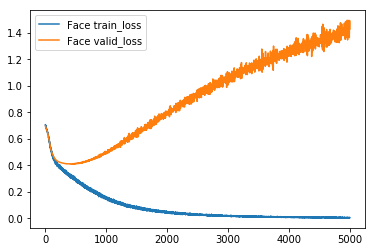

In [16]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='Face train_loss')
mplot.plot(valid_loss, label='Face valid_loss')
mplot.legend()
mplot.show()

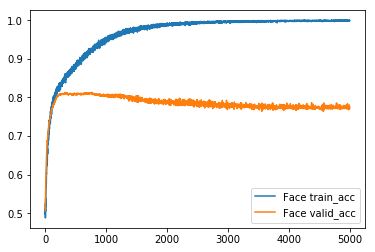

In [17]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc, label='Face train_acc')
mplot.plot(valid_acc, label='Face valid_acc')
mplot.legend()
mplot.show()

In [18]:
test_acc, test_loss = [], []

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints_/'))
    
    ################## Test
    acc_batch = []
    loss_batch = []    
    # Loop over batches
    for x, y in get_batches(batch_size=100, X=X_test_norm, y=Y_test_onehot):

        # Feed dictionary
        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

        # Loss
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Store
    test_acc.append(np.mean(acc_batch))
    test_loss.append(np.mean(loss_batch))

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(test_loss)),
          "Test acc: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints_/dcnn-face-yalda.ckpt
Test loss: 0.680941 Test acc: 0.887857
